In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os


In [21]:
FIGRATIO = 2 / 5
FIGWIDTH = 10  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)

plt.rcParams.update(
    {
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True,
    }
)

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

# Define task names
producer_task_name = "task::MapBatches(produce_video_slices)"
consumer_task_name = "task::MapBatches(preprocess_video)"
no_parallel_task_name = "task::MapBatches(produce_video_slices)->MapBatches(preprocess_video)"
gpu_task_name = "task::MapBatches(Classifier)"

In [16]:
def plot_task_timeline(df, ax):
    global_start = 0
    for index, row in df.iterrows():
        if global_start == 0:
            global_start = row.name
            break
    # Populate worker id for y coordinates
    df = df[(df.index - global_start) / 1_000_000 >= 10]
    df = df[(df["cat"] == producer_task_name) | (df["cat"] == consumer_task_name)]
    unique_workers = df["tid"].unique()
    y_coordinates = {worker: index - 1 for index, worker in enumerate(unique_workers)}

    min_start = 1000
    ax.plot([0, 0], [0, 0])  # Note: for add_patch to work
    for index, row in df.iterrows():
        start_time = (index - global_start) / 1_000_000
        min_start = min(min_start, start_time)
        duration = row["dur"] / 1_000_000
        task_name = row["cat"]
        worker = row["tid"]
        y_coordinate = y_coordinates[worker]

        color_index = 1 if task_name == producer_task_name else 2
        color = COLORS[color_index]

        ax.add_patch(
            plt.Rectangle(
                (start_time - min_start, y_coordinate),
                duration,
                0.5,
                fill=True,
                facecolor=color,
                edgecolor="grey",
                zorder=100,
            )
        )

    ax.set_xlabel("Time (s)", fontsize=20)
    ax.yaxis.set_visible(False)
    ax.tick_params(axis="x", labelsize=20)

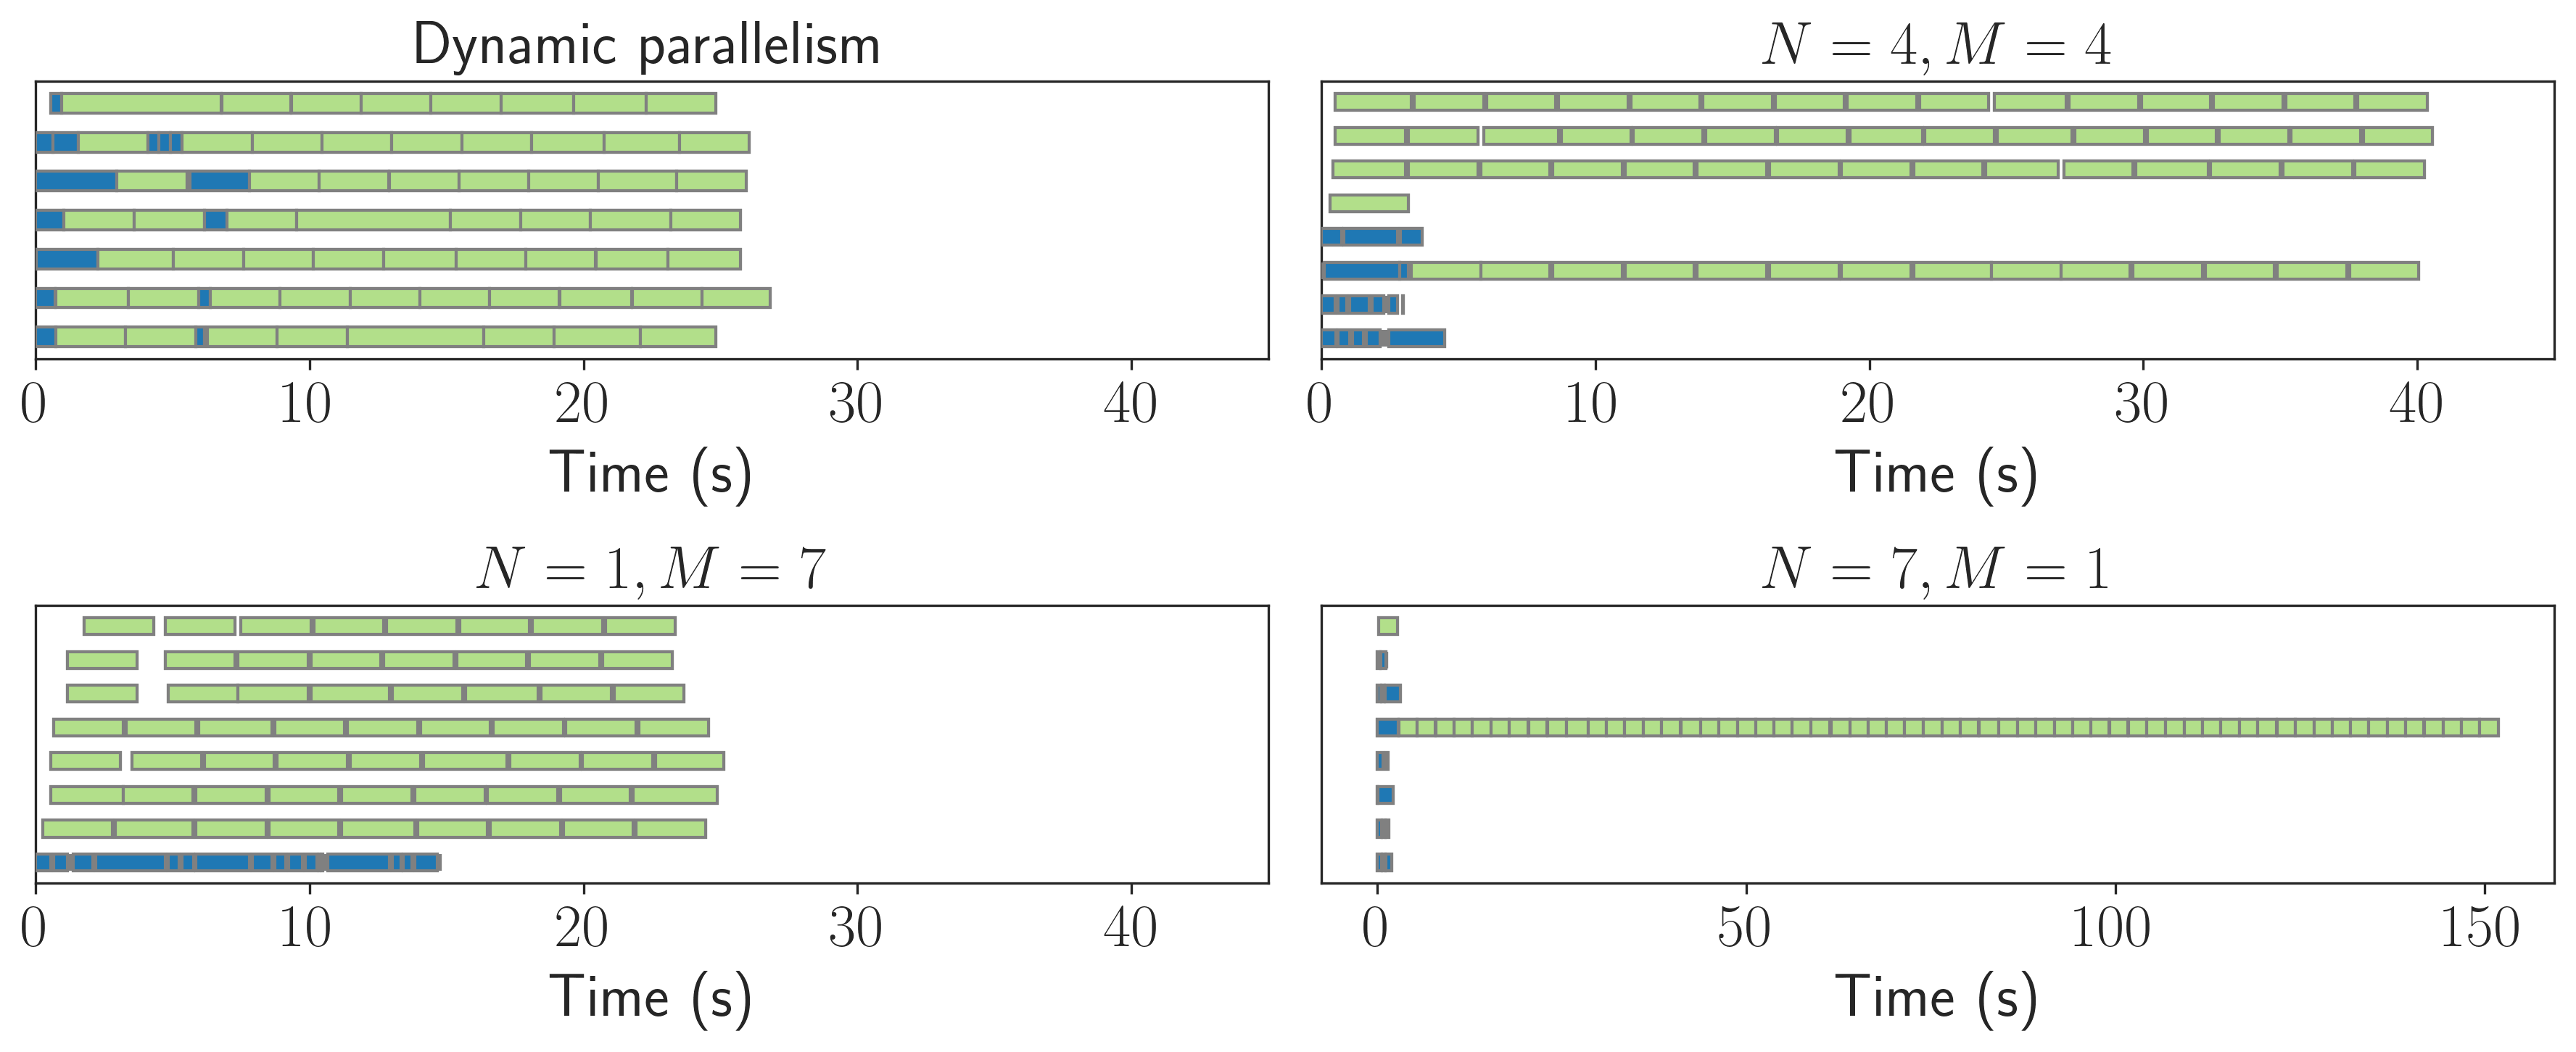

In [18]:
# Create a figure and axis
directory = "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/logs/"
file_paths = [
    "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/logs/Dynamic parallelism.json",
    "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/logs/$N=4, M=4$.json",
    "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/logs/$N=1, M=7$.json",
    "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/logs/$N=7, M=1$.json",
]

num_plots = len(file_paths)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 5))

for i, file_path in enumerate(file_paths):
    df = pd.read_json(file_path)
    df.set_index("ts", inplace=True)
    df.sort_index(inplace=True)
    plot_task_timeline(df, axs[i // num_cols, i % num_cols])
    file_name = os.path.basename(file_path)[:-5]
    if os.path.basename(file_path)[:-5] != "$N=7, M=1$":
        axs[i // num_cols, i % num_cols].set_xlim(0, 45)
    plot_task_timeline(df, axs[i // num_cols, i % num_cols])
    axs[i // num_cols, i % num_cols].set_title(file_name, fontsize=20)

plt.tight_layout()
plt.savefig("long-video-dyn-parallelism.pdf")
plt.show()

In [19]:
def plot_task_timeline_with_gpu(df, ax):
    global_start = 0
    for index, row in df.iterrows():
        if global_start == 0:
            global_start = row.name
            break

    df = df[(df.index - global_start) / 1_000_000 >= 51]
    # Populate worker id for y coordinates
    df = df[
        (df["cat"] == producer_task_name)
        | (df["cat"] == consumer_task_name)
        | (df["cat"] == gpu_task_name)
        | (df["cat"] == no_parallel_task_name)
    ]
    unique_workers = df["tid"].unique()
    y_coordinates = {worker: index - 1 for index, worker in enumerate(unique_workers)}
    print("y_coordinates", y_coordinates)

    min_start = 1000
    ax.plot([0, 0], [0, 0])  # Note: for add_patch to work
    for index, row in df.iterrows():
        start_time = (index - global_start) / 1_000_000
        min_start = min(min_start, start_time)
        duration = row["dur"] / 1_000_000
        task_name = row["cat"]
        worker = row["tid"]
        y_coordinate = y_coordinates[worker]

        color_index = 0
        if task_name == producer_task_name or task_name == no_parallel_task_name:
            color_index = 1
        elif task_name == consumer_task_name:
            color_index = 2
        else:
            color_index = 4
        color = COLORS[color_index]

        ax.add_patch(
            plt.Rectangle(
                (start_time - min_start, y_coordinate),
                duration,
                0.5,
                fill=True,
                facecolor=color,
                edgecolor="grey",
                zorder=100,
            )
        )

    ax.set_xlabel("Time (s)", fontsize=15)
    ax.yaxis.set_visible(False)
    ax.tick_params(axis="x", labelsize=13)

y_coordinates {'worker:7866a9bd71a9e0f33283ccd13dcb6d22e197ddb63ece54d504fb5962': -1, 'worker:4115556b43ce156178879769860e95df31ae51de41fab503987240b9': 0, 'worker:b423db85eadc69600c003e622582556b18abdb53dbe59418ef04fe1b': 1}
y_coordinates {'worker:067a130e2e8f863cb8ad6d13197ef19cdedb4f459d744f63b667411e': -1, 'worker:efe30edb626af088ebe6d9f4c71b0b9f1a9bdc98ca4c58c77c34cd70': 0, 'worker:1b4ae7d1ae1f9d389474f4ccea654d116091820d85df56ed5ac18791': 1, 'worker:8c5c158e08a9b9abef8c57b5614e7f8a6fb34ac9dc0e037d3c3825e6': 2, 'worker:c1898d4f66eb08ee9cf7e71f2110ef78d2d975ae5f1073eee8298428': 3, 'worker:a27b39af161dad6d457fc1795ce918432a81cd7ed41816cc368625a1': 4, 'worker:23a21ca43aba5c260737925dce8906920efba302bccda73f6e4839d5': 5, 'worker:c78c1adae05e0f2391e2d63798b04e2489d46012036edd26d27ea90c': 6, 'worker:bd068707313ceb2185819cdd756ba31fec118cd4ebfac0716007eede': 7}


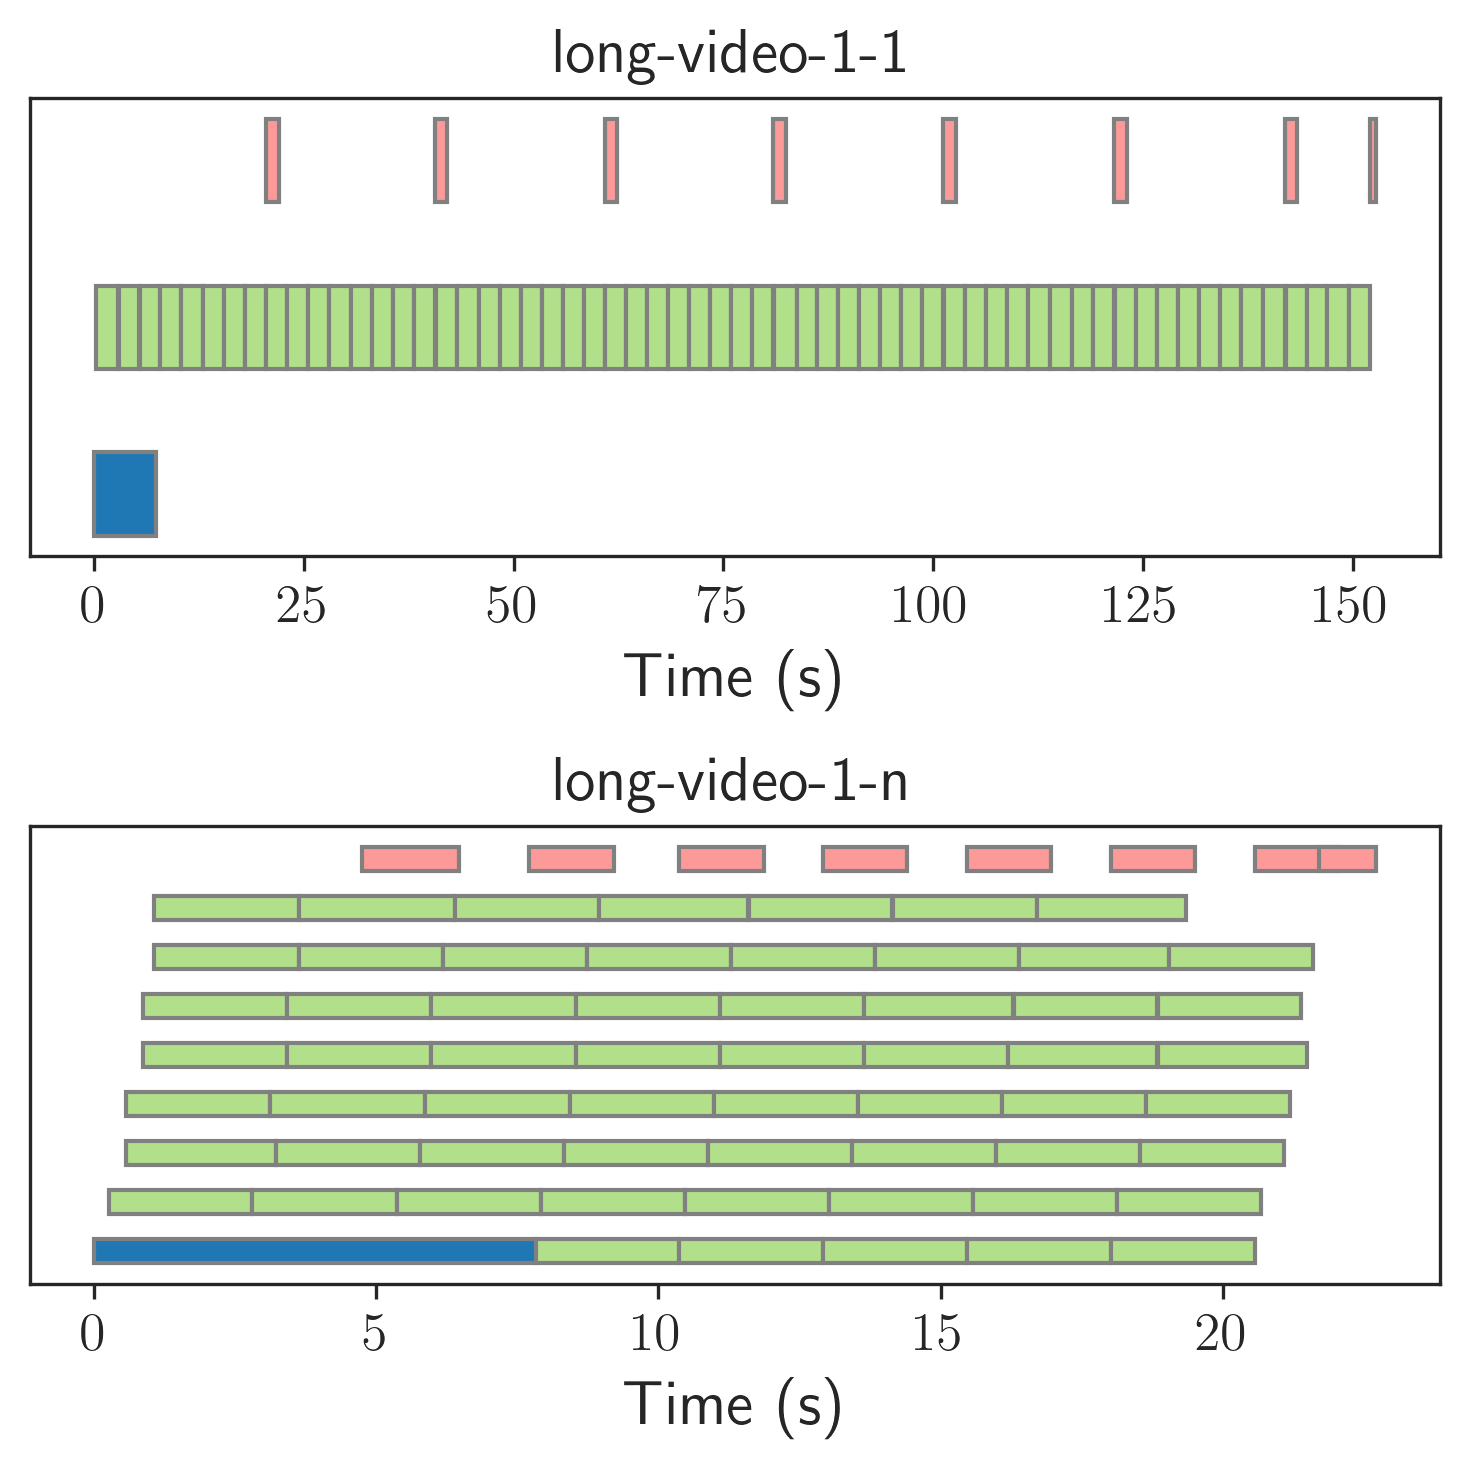

In [47]:
# Create a figure and axis
directory = "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/logs/"
file_paths = [
    "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/logs/long-video-1-1.json",
    "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/long_video/logs/long-video-1-n.json",
]

num_plots = len(file_paths)
num_cols = 1
num_rows = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 5))

for i, file_path in enumerate(file_paths):
    df = pd.read_json(file_path)
    df.set_index("ts", inplace=True)
    df.sort_index(inplace=True)
    if os.path.basename(file_path)[:-5] == "longvideo-no-parallel":
        axs[i].set_ylim(-1, 7)
        axs[i].set_yticks(range(-1, 7, 2))
        axs[i].set_title("Without dynamic repartitioning", fontsize=20)
    else:
        axs[i].set_title("With dynamic repartitioning", fontsize=20)

    plot_task_timeline_with_gpu(df, axs[i])
    file_name = os.path.basename(file_path)[:-5]

plt.tight_layout()
plt.savefig("long-video-gpu.pdf")
plt.show()